Fatemeh Mohammadi - 810199489

# Step Zero:

## Import Libraries:

In [1]:
!pip install librosa numpy soundfile matplotlib noisereduce scipy
!pip install hmmlearn colorama collections scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [198]:
import librosa
import numpy as np
import os
import soundfile as sf
import matplotlib.pyplot as plt
import noisereduce as nr
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from colorama import Fore, Style
from collections import defaultdict
import scipy.stats
from sklearn.metrics import confusion_matrix

# Step One:

## Set Parameters 

In [130]:
initial_recordings_folder = 'recordings'
preprocessed_recordings_folder = 'preprocessed_recordings'
mfcc_features_folder = 'mfcc_features'

DIGITS = []
SPEAKERS = []

TARGET_SAMPLING_RATE = 16000

N_MFCC = 13
N_TIME_MFCC = 30

NUM_REPEATED_RECORDING = 50

TRAIN_PERCENT = 0.3
TEST_PERCENT = 0.7

NUM_STATE = 13
NUM_ITERATION = 10

## Preprocessing:

In [4]:
def preprocess_audio(input_path, output_path, target_sampling_rate = TARGET_SAMPLING_RATE):
    # Load the audio file
    audio, sampling_rate = librosa.load(input_path, sr = target_sampling_rate)

    # Noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr = sampling_rate)

    # Silence removal
    non_silent_audio, _ = librosa.effects.trim(audio)

    # Normalize the audio to a standard volume level
    normalized_audio = librosa.util.normalize(non_silent_audio)

    # Save the processed audio file
    sf.write(output_path, normalized_audio, target_sampling_rate)

In [5]:
def preprocess_all_audio(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(input_folder, file_name)
            output_path = os.path.join(output_folder, file_name)
            preprocess_audio(file_path, output_path)
            #print(f"Processed {file_name}")

In [6]:
preprocess_all_audio(initial_recordings_folder, preprocessed_recordings_folder)

## Feature Extraction

### Extract MFCC

In [7]:
def pad_mfcc(raw_mfcc, n_time_mfcc = N_TIME_MFCC):
    temp = np.tile(raw_mfcc, (1 ,int(np.ceil(n_time_mfcc / raw_mfcc.shape[1])) ))
    padded_mfcc_features= temp[:,:n_time_mfcc]
    return padded_mfcc_features

In [8]:
def extract_mfcc(file_path, target_sampling_rate = TARGET_SAMPLING_RATE, n_mfcc = N_MFCC, n_time_mfcc = N_TIME_MFCC):
    audio, _ = librosa.load(file_path)
    raw_mfcc = librosa.feature.mfcc(y = audio, sr = target_sampling_rate, n_mfcc = n_mfcc)
    mfcc = pad_mfcc(raw_mfcc, n_time_mfcc)
    return mfcc

In [9]:
def extract_features_for_all_files(recordings_folder, mfcc_folder):
    if not os.path.exists(mfcc_folder):
        os.makedirs(mfcc_folder)

    for file_name in os.listdir(recordings_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(recordings_folder, file_name)
            mfcc_feature = extract_mfcc(file_path)
            # Save mfcc_feature as file
            output_file_path = os.path.join(mfcc_folder, file_name.replace('.wav', '.npy'))
            np.save(output_file_path, mfcc_feature)
            #print(f"MFCC features extracted and saved for {file_name} , shape = {mfcc_feature.shape}")

In [10]:
extract_features_for_all_files(preprocessed_recordings_folder, mfcc_features_folder)

MFCC features extracted and saved for 0_george_0.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_1.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_10.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_11.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_12.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_13.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_14.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_15.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_16.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_17.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_18.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_19.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_2.wav , shape = (13, 30)
MFCC features extracted and saved for 0_george_20.wav 

### Heat Map:

In [11]:
def plot_mfcc_heatmaps(mfcc_folder, n_mfcc = N_MFCC):
    for file_name, mfcc in mfcc_folder.items():
        plt.figure(figsize=(15, 5))
        plt.title(f'MFCC Heatmap for {file_name}')
        librosa.display.specshow(mfcc, x_axis='time')
        plt.yticks(range(0, n_mfcc))
        plt.ylabel('MFCC')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

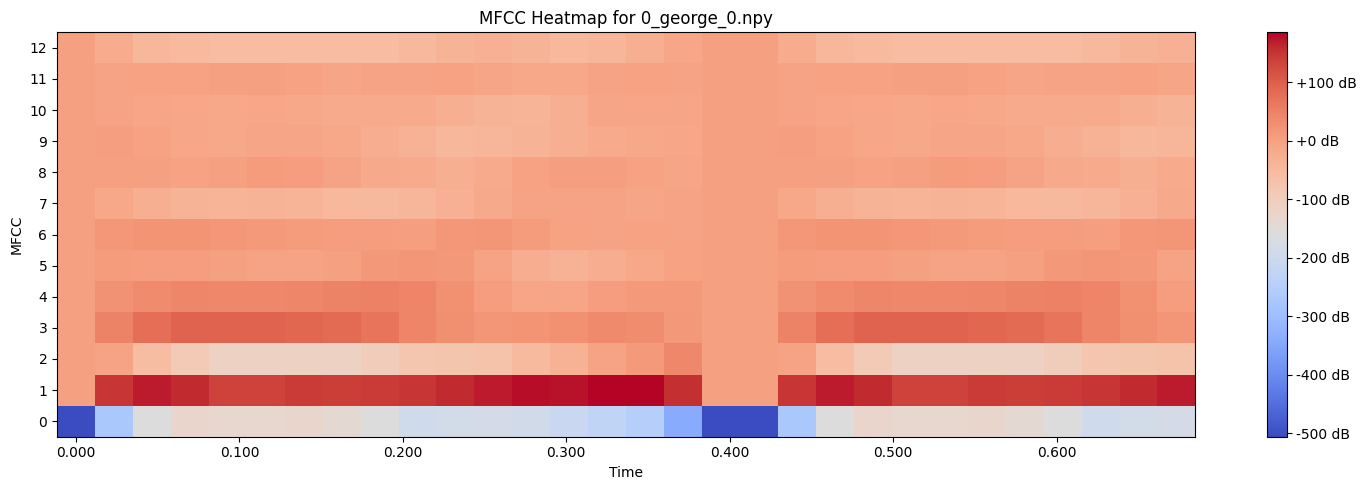

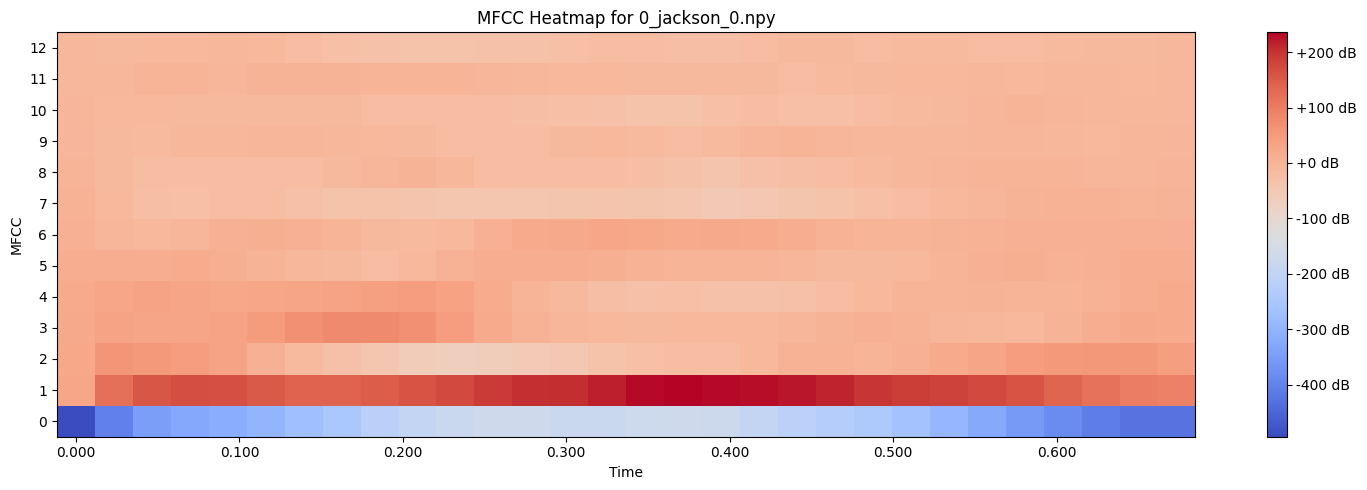

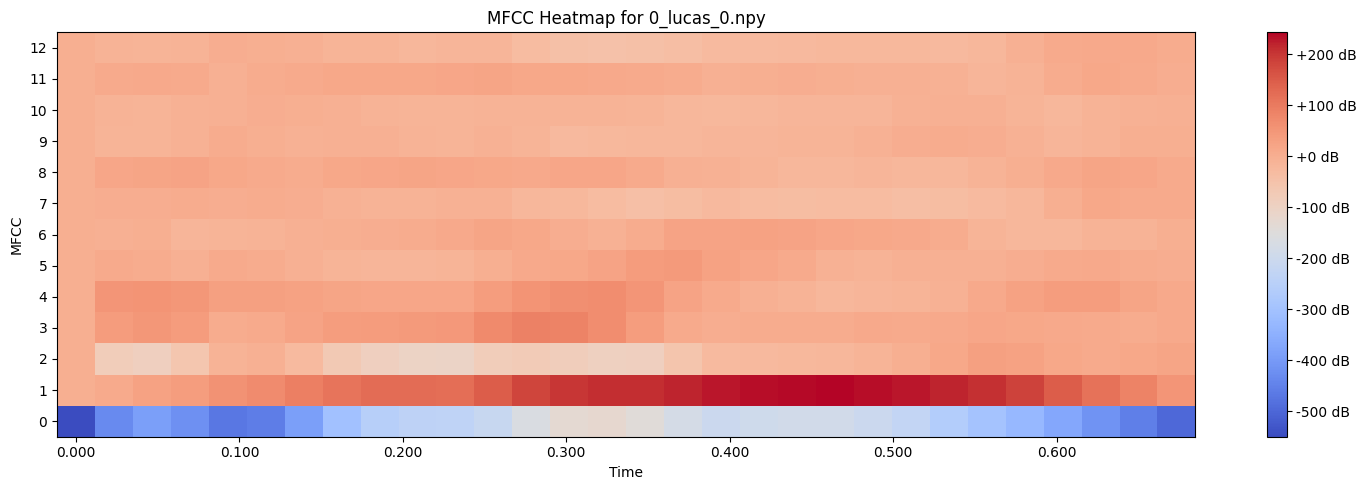

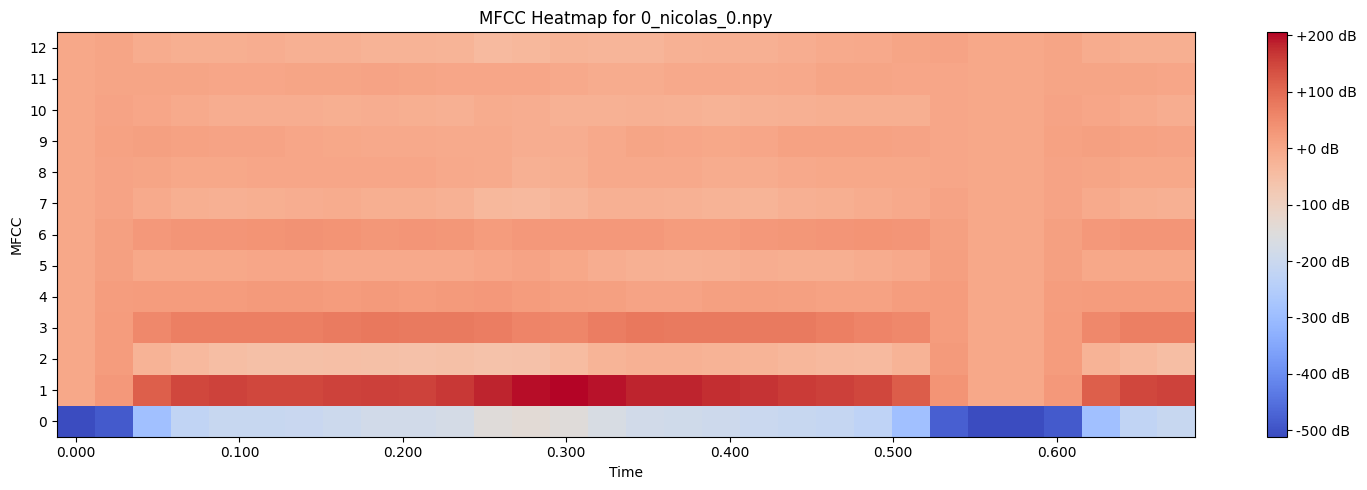

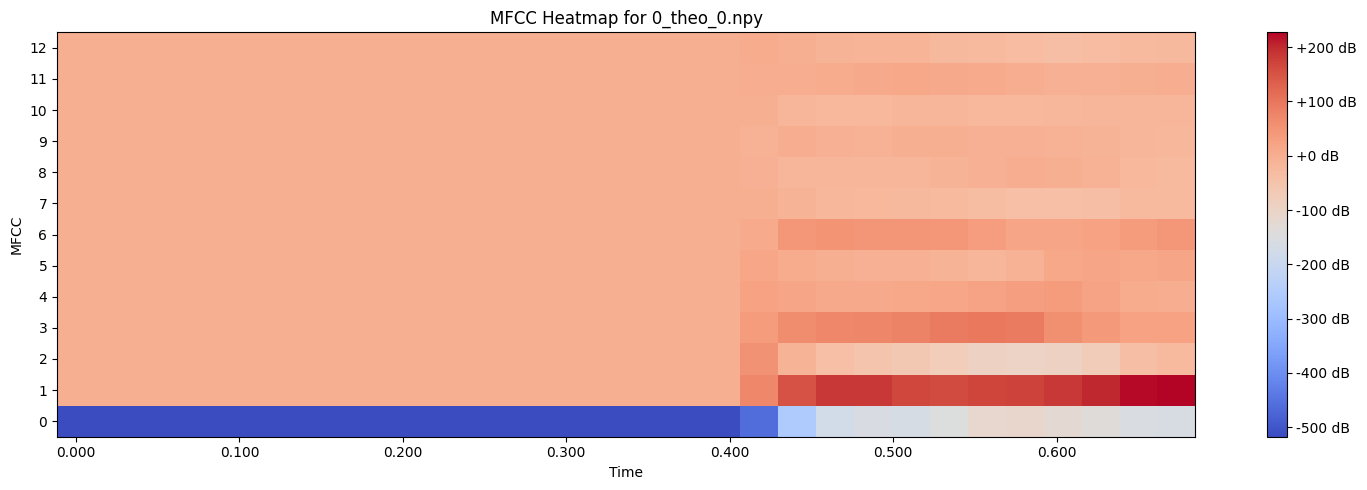

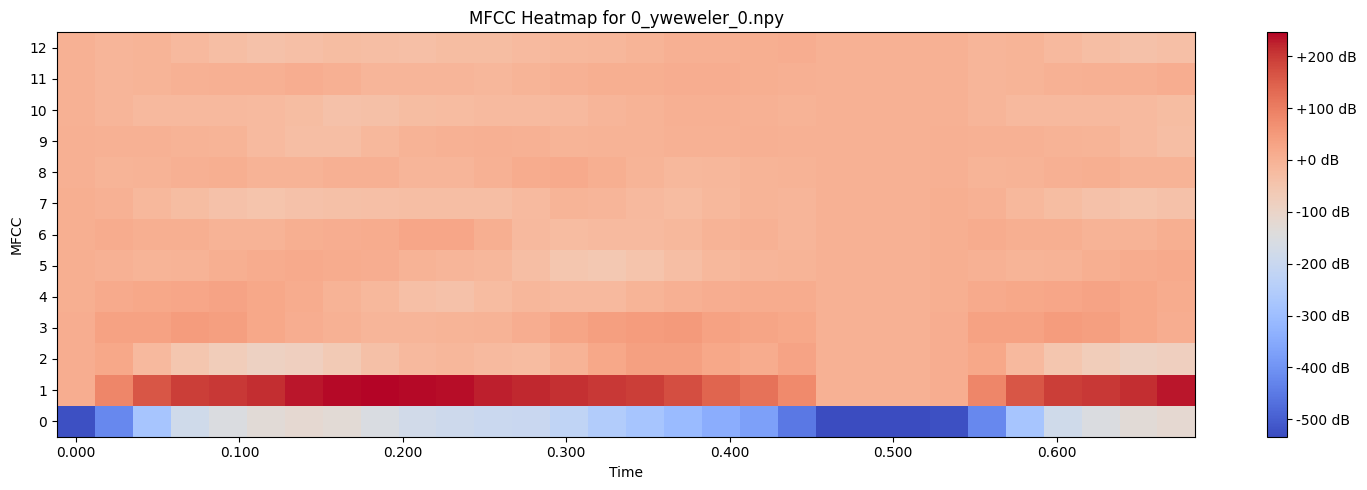

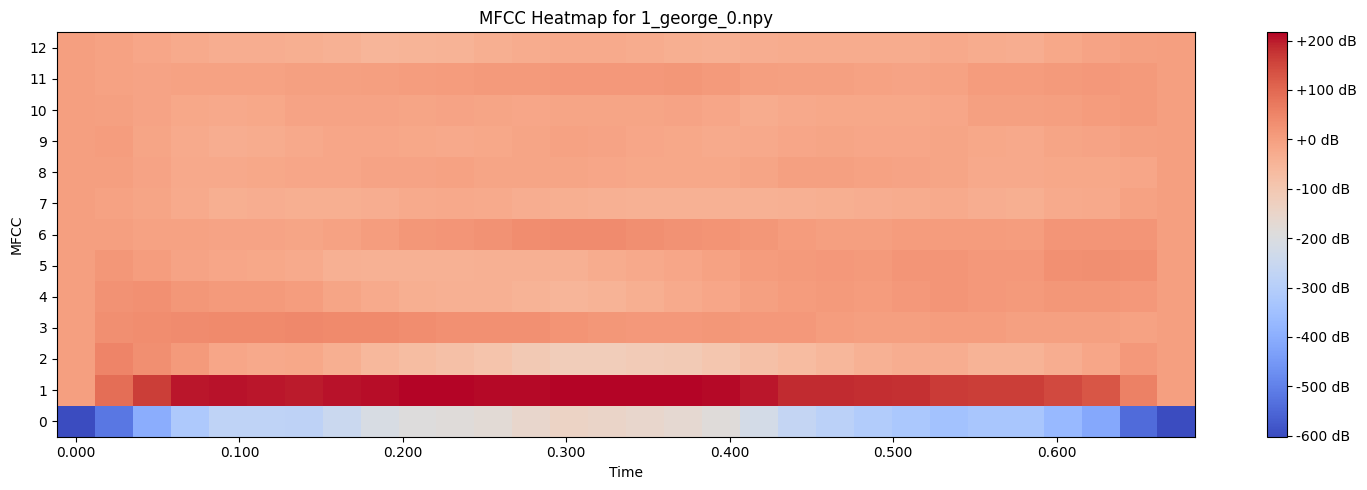

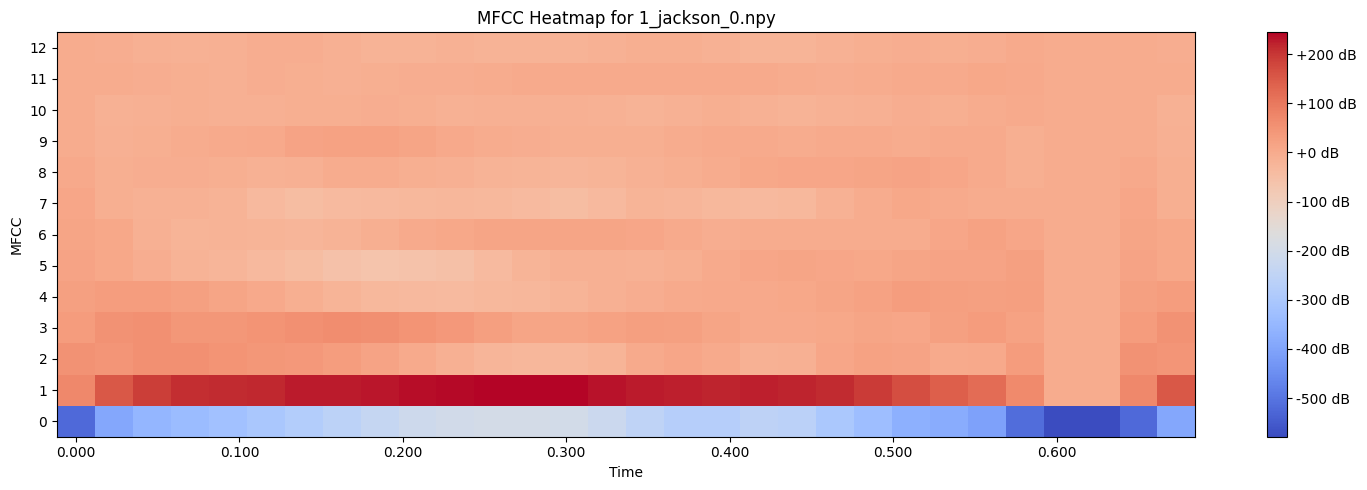

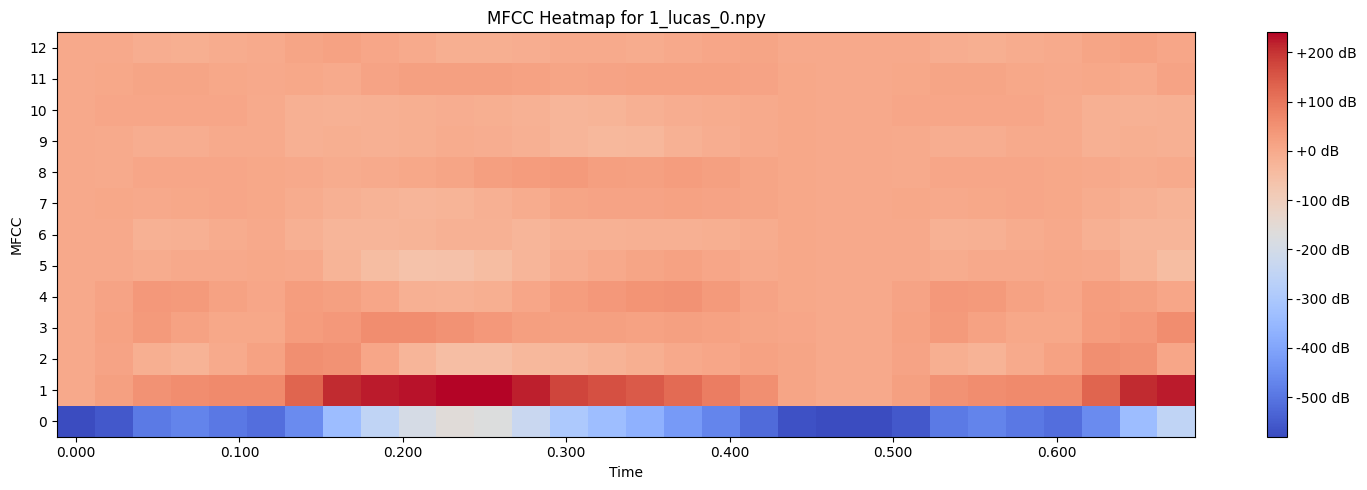

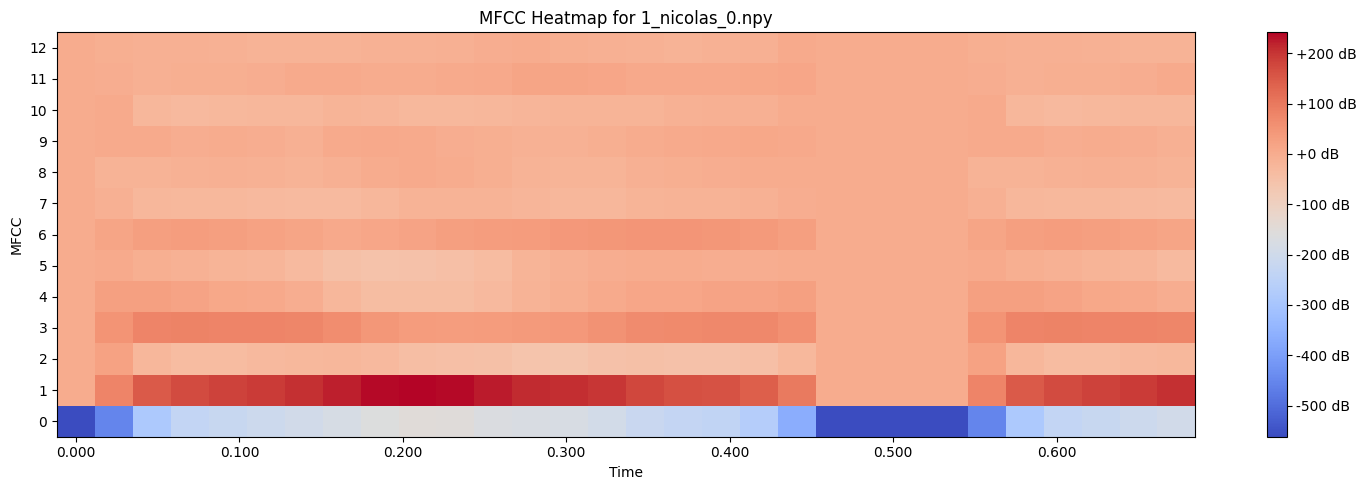

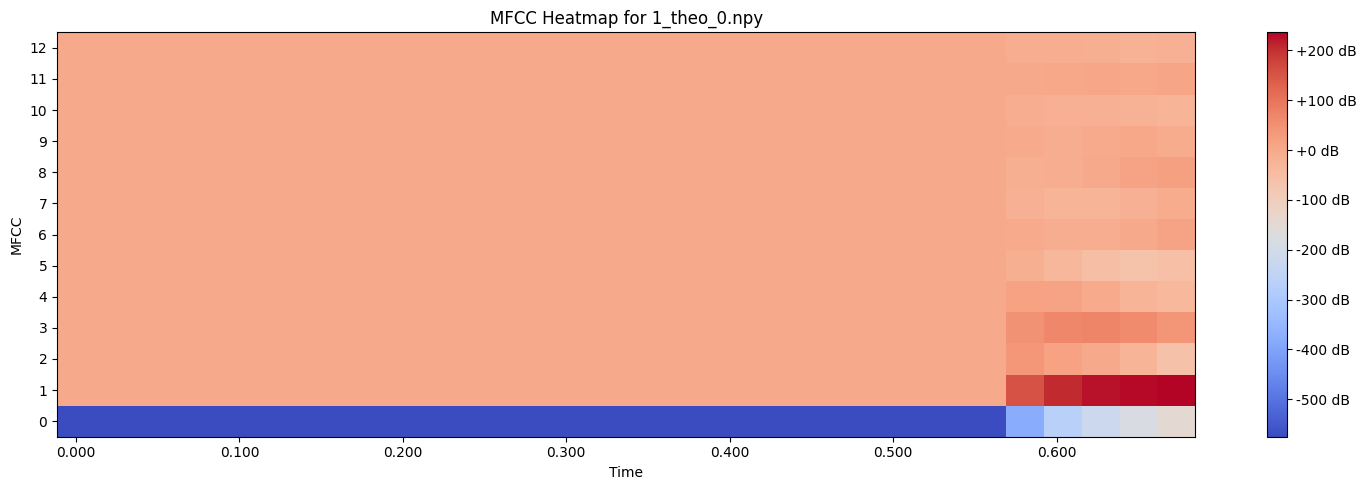

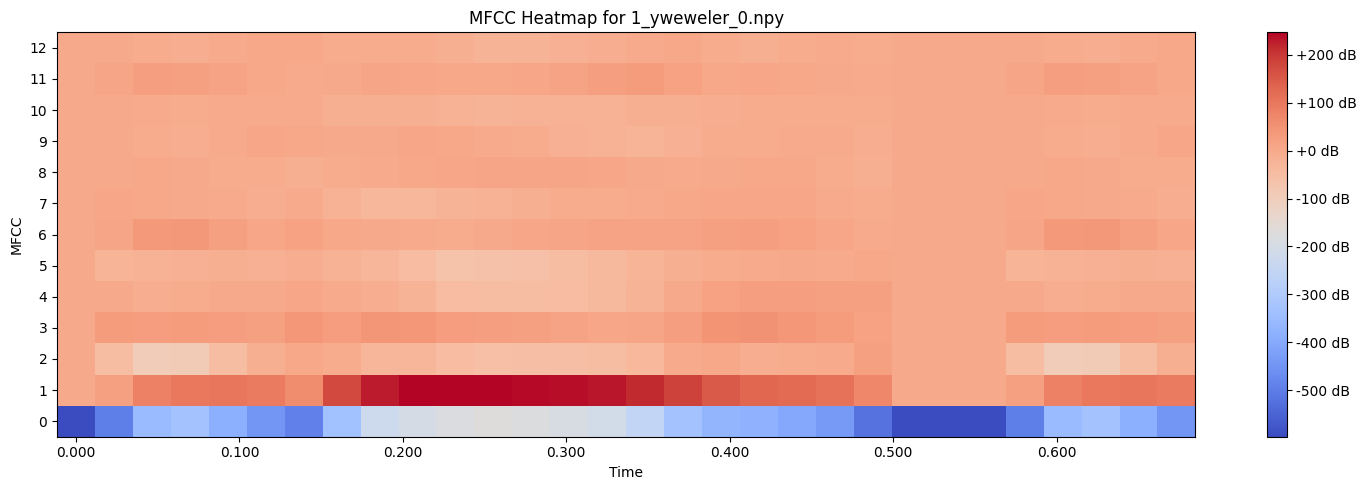

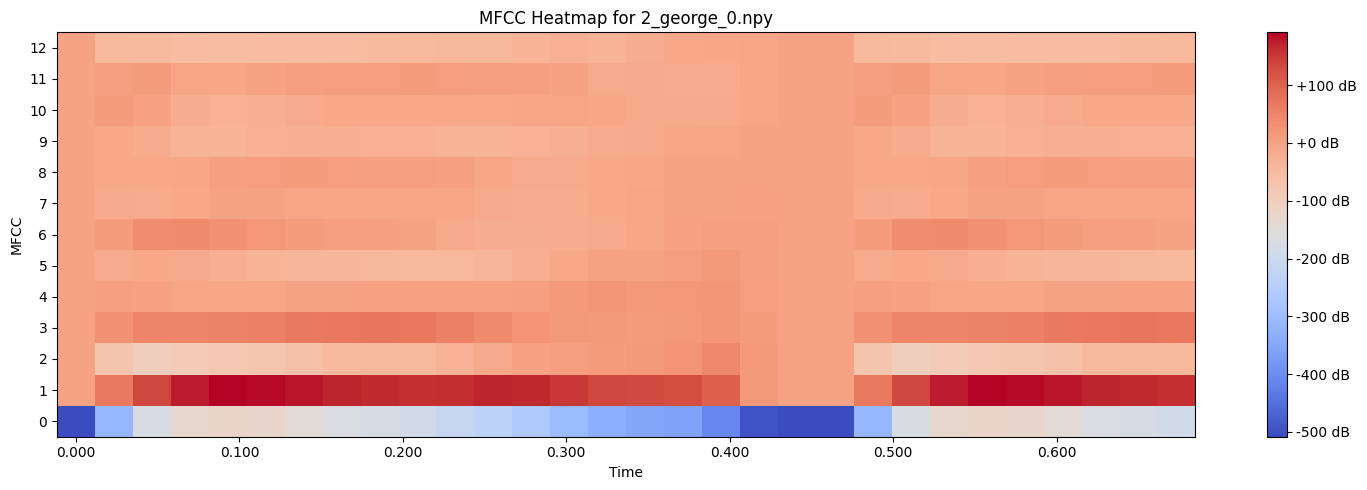

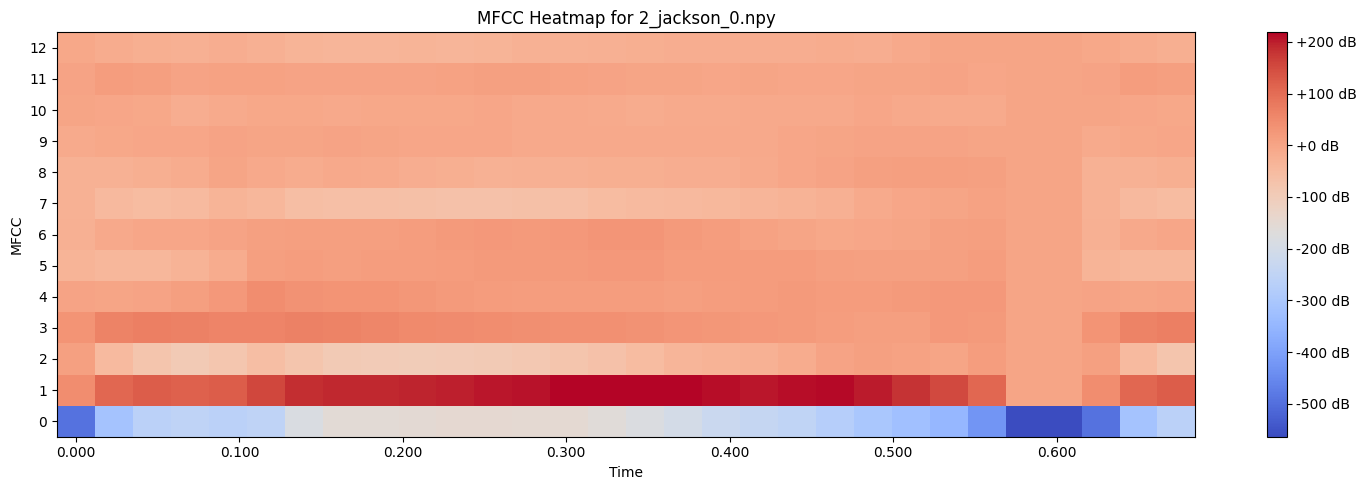

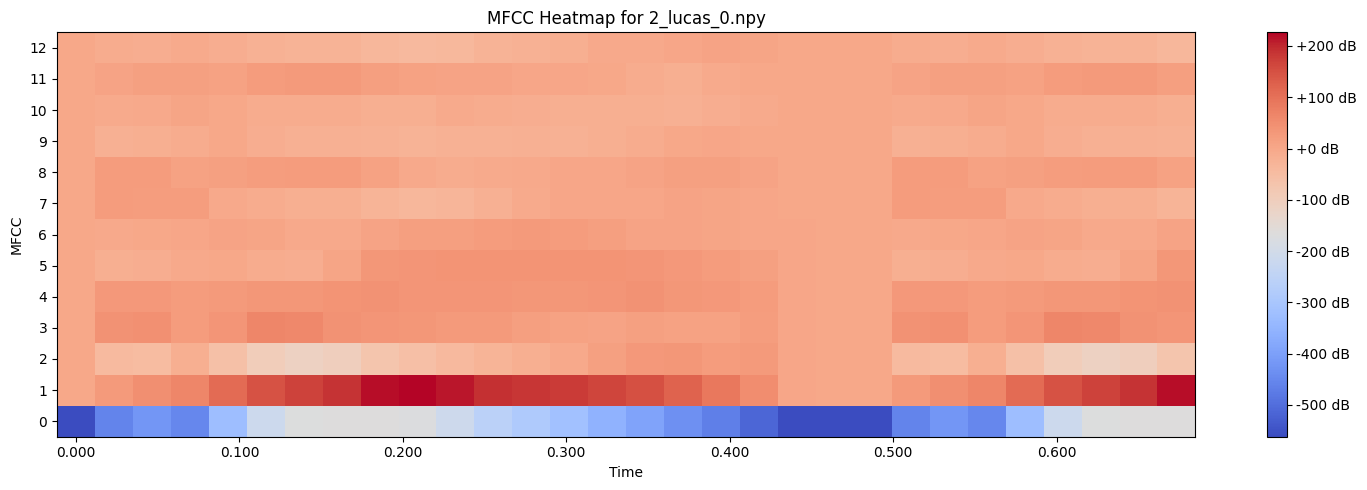

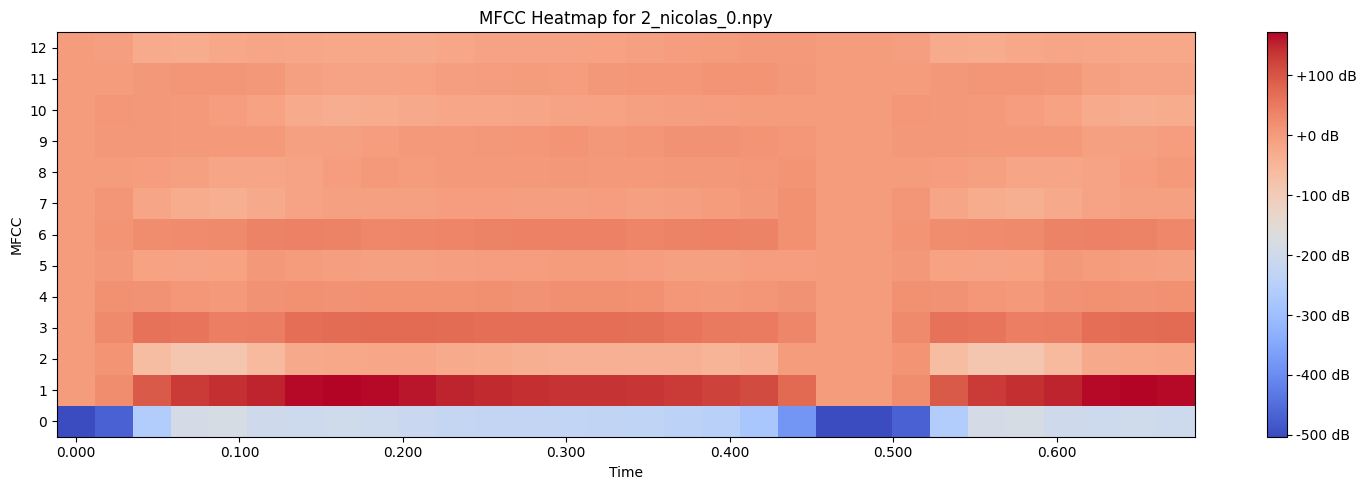

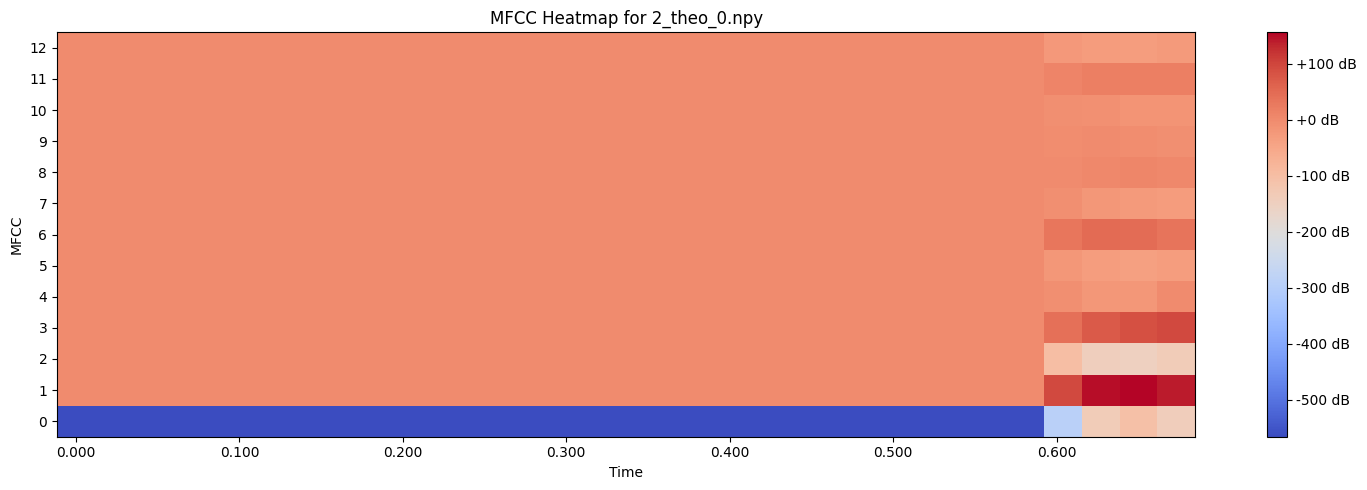

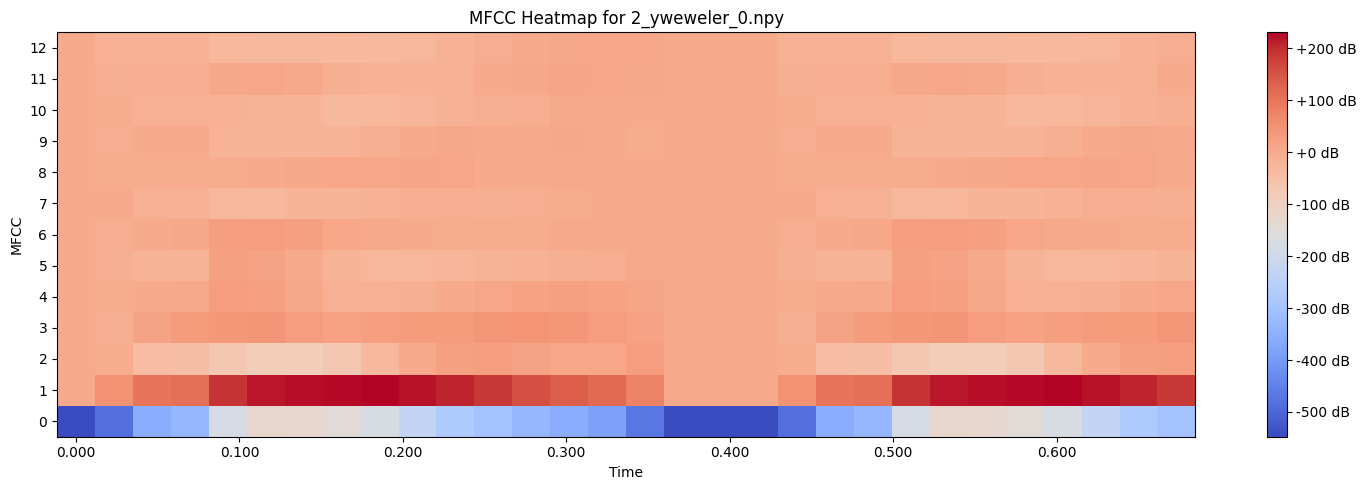

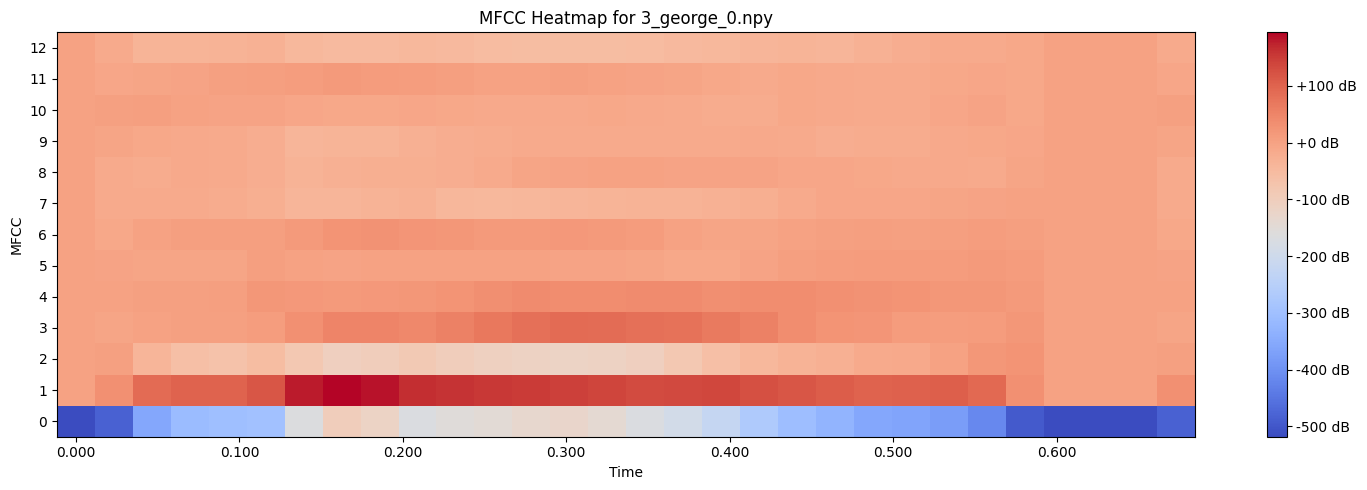

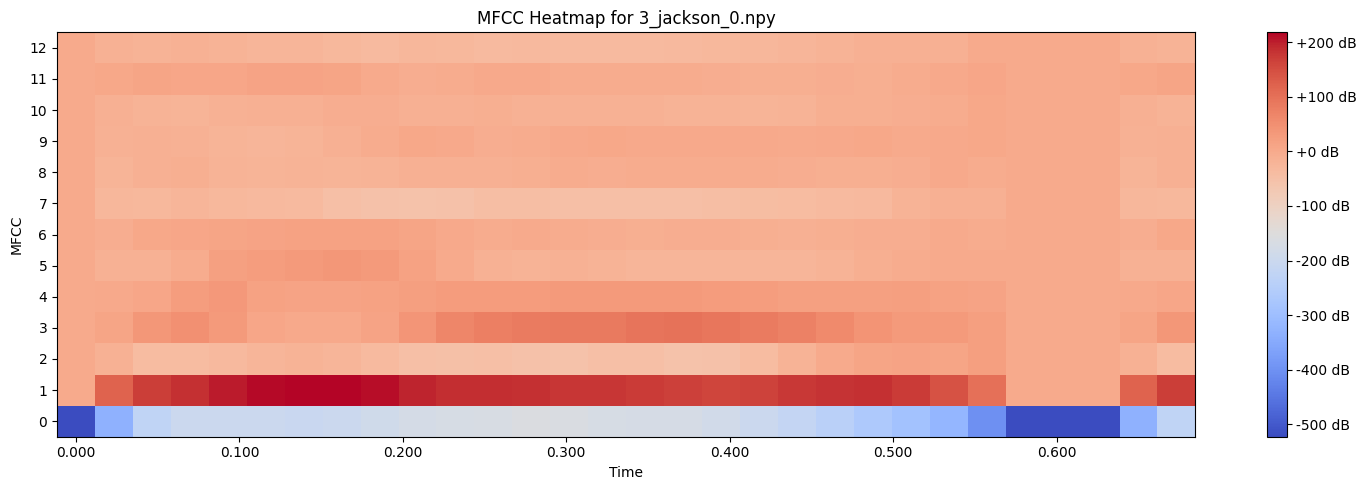

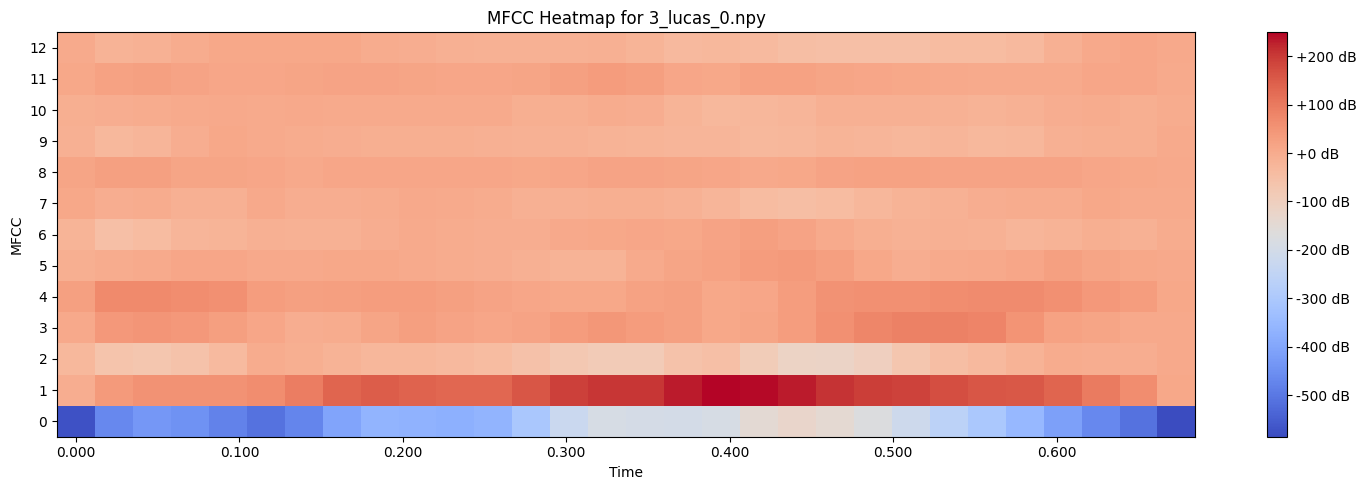

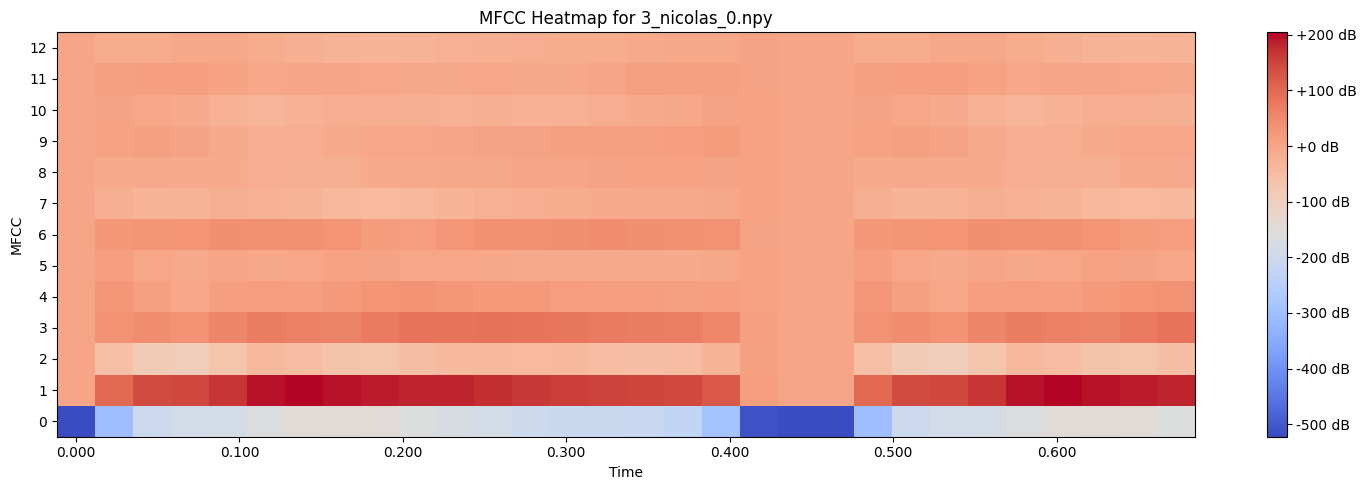

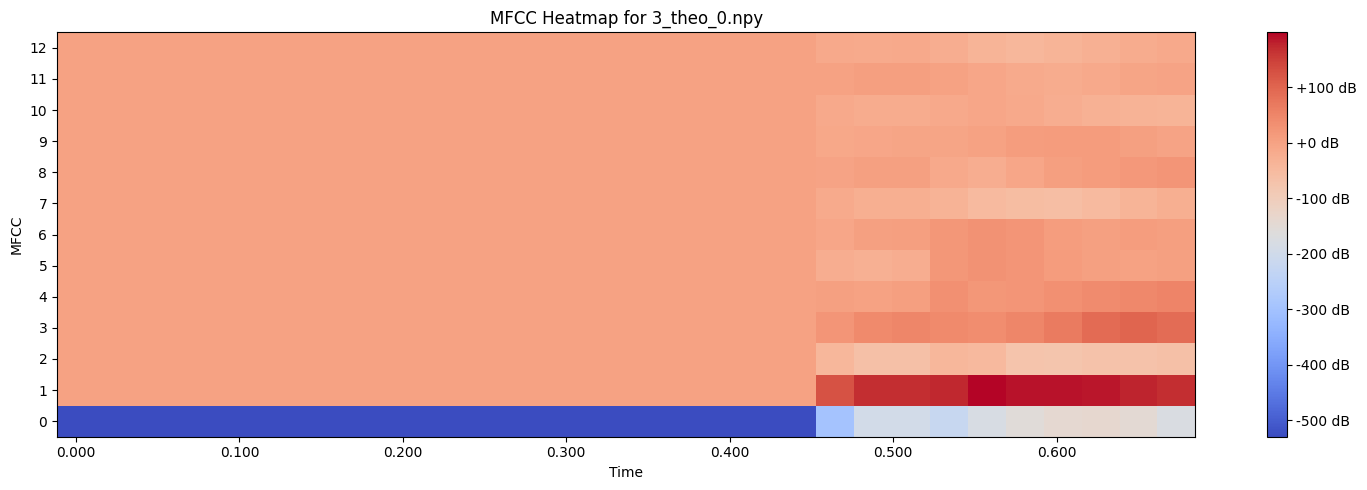

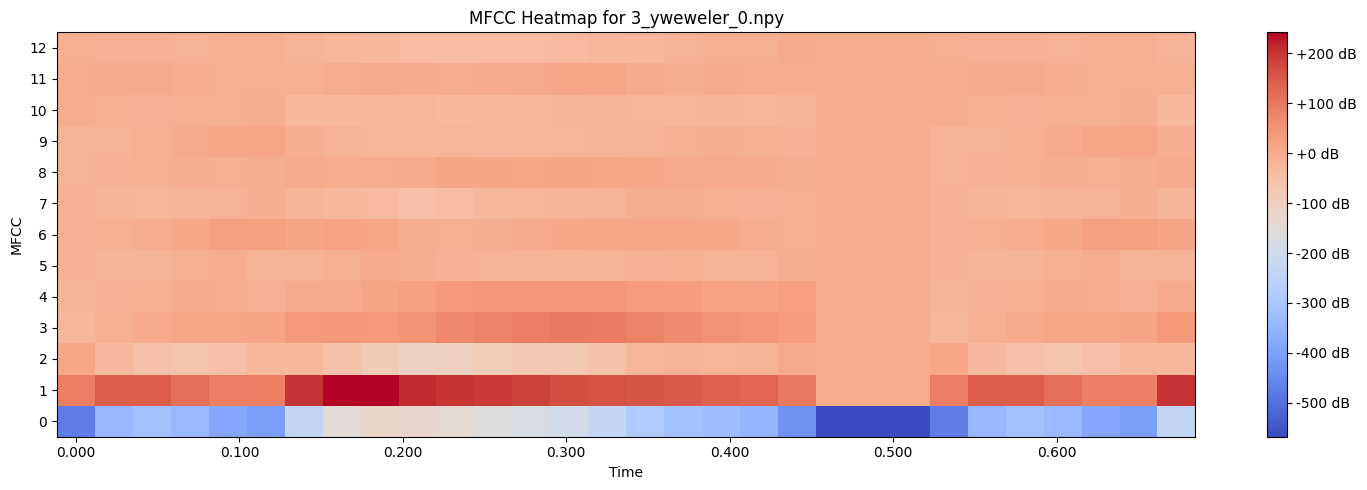

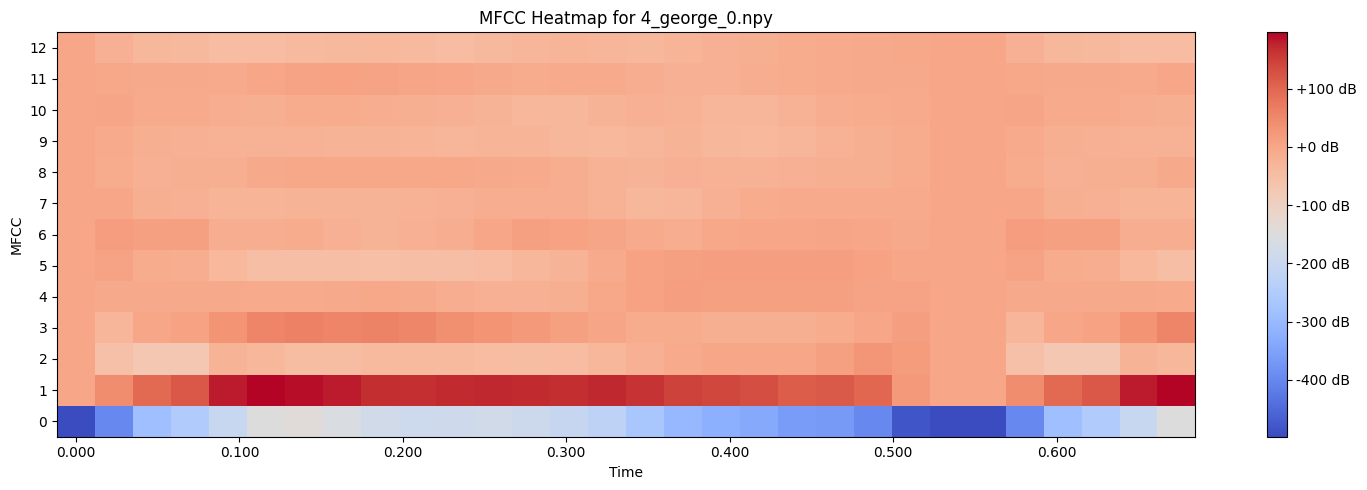

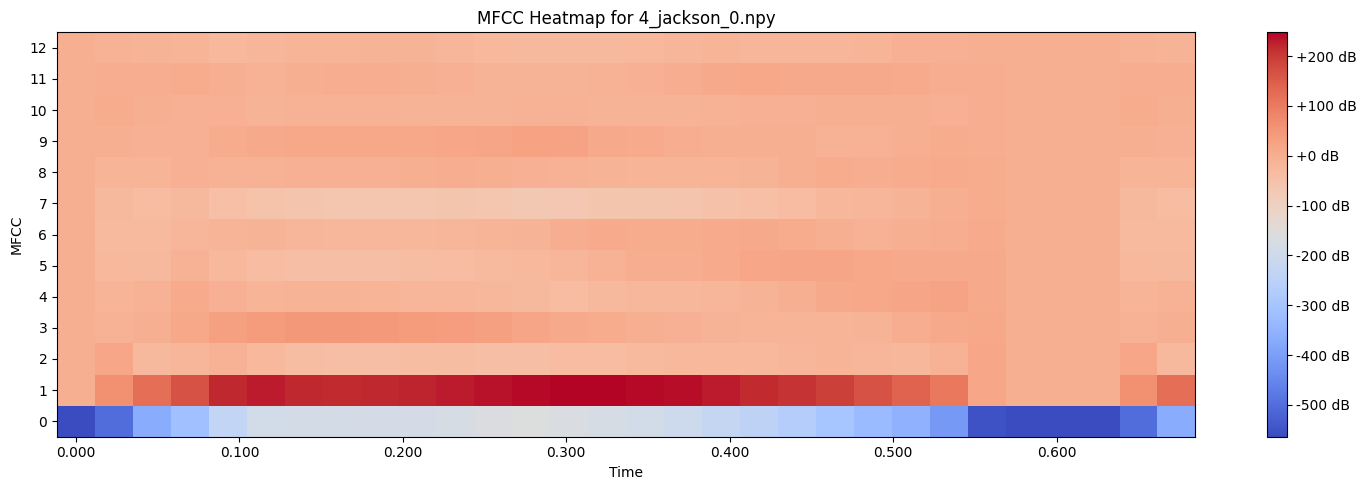

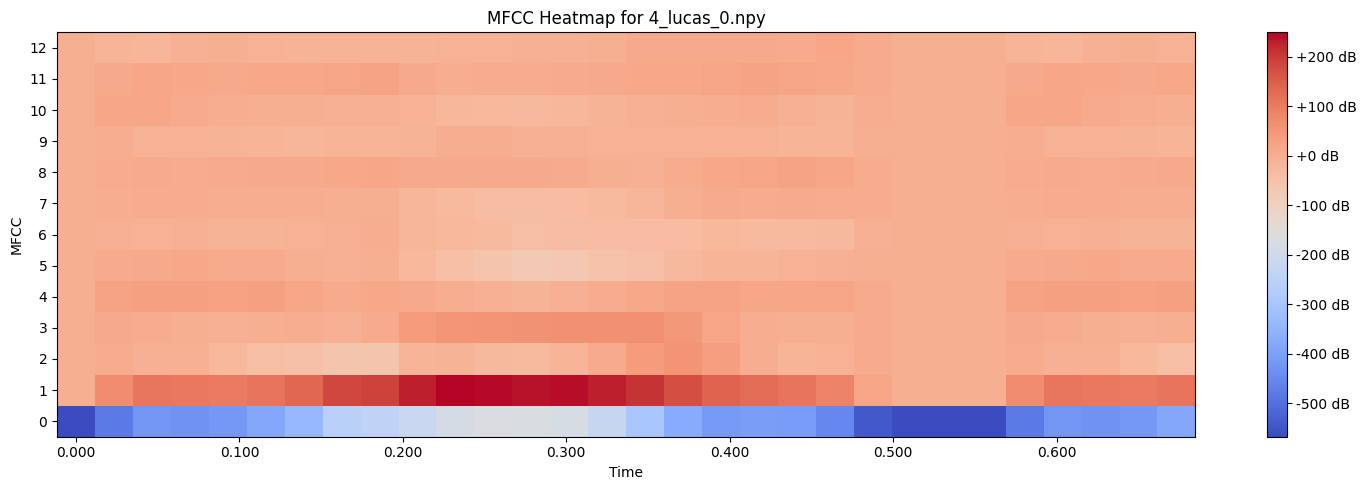

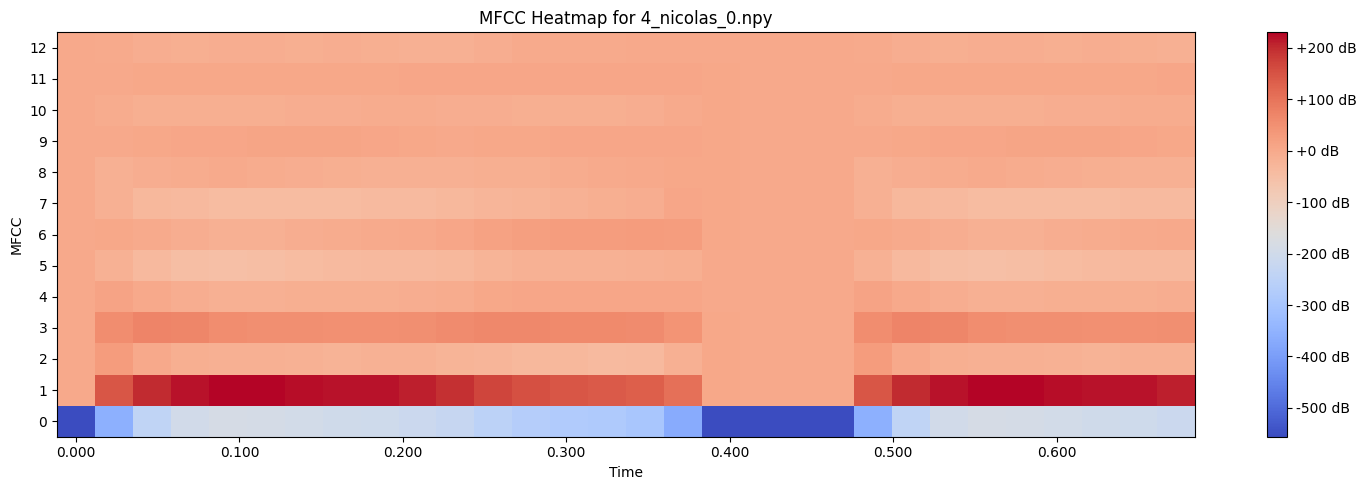

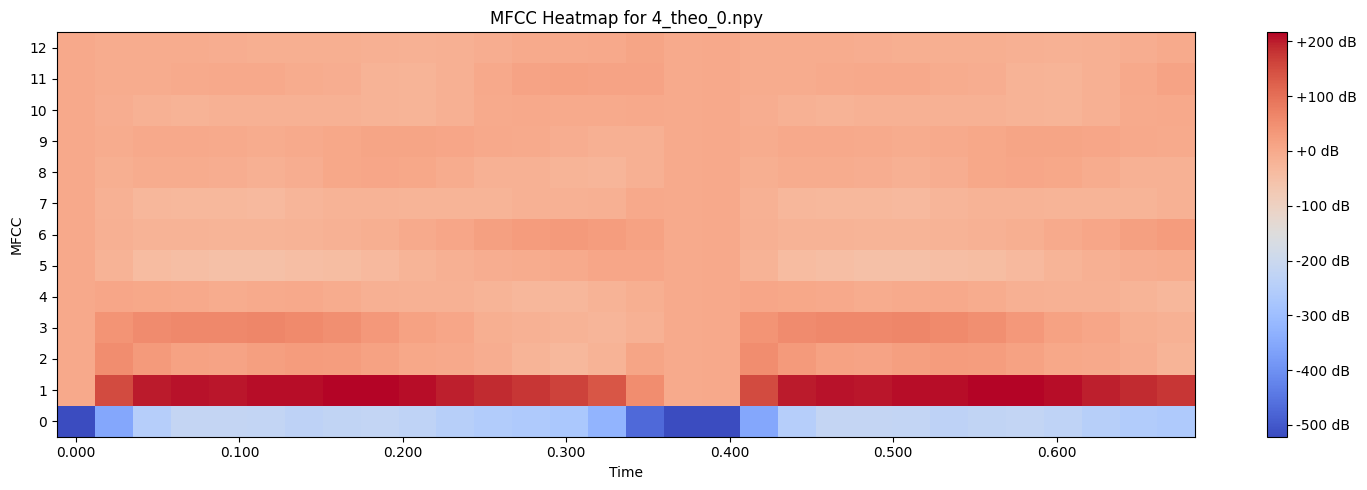

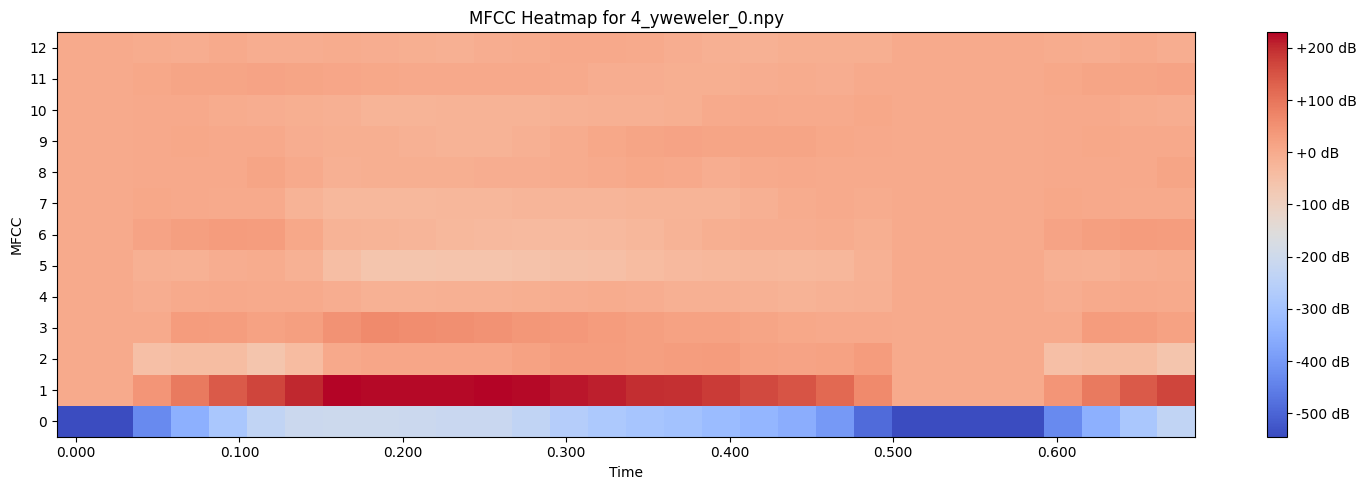

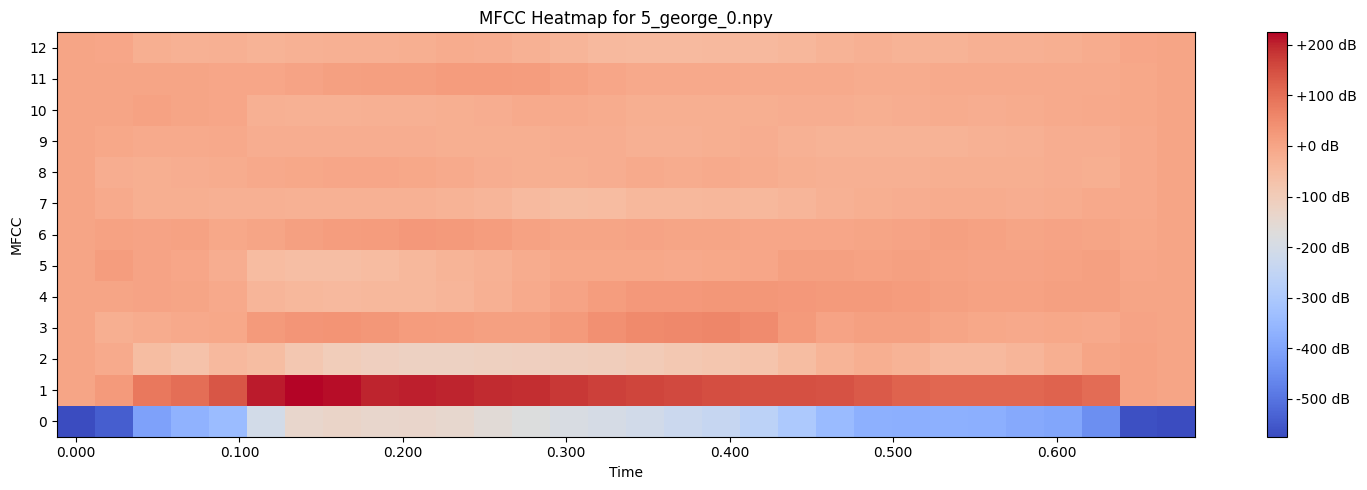

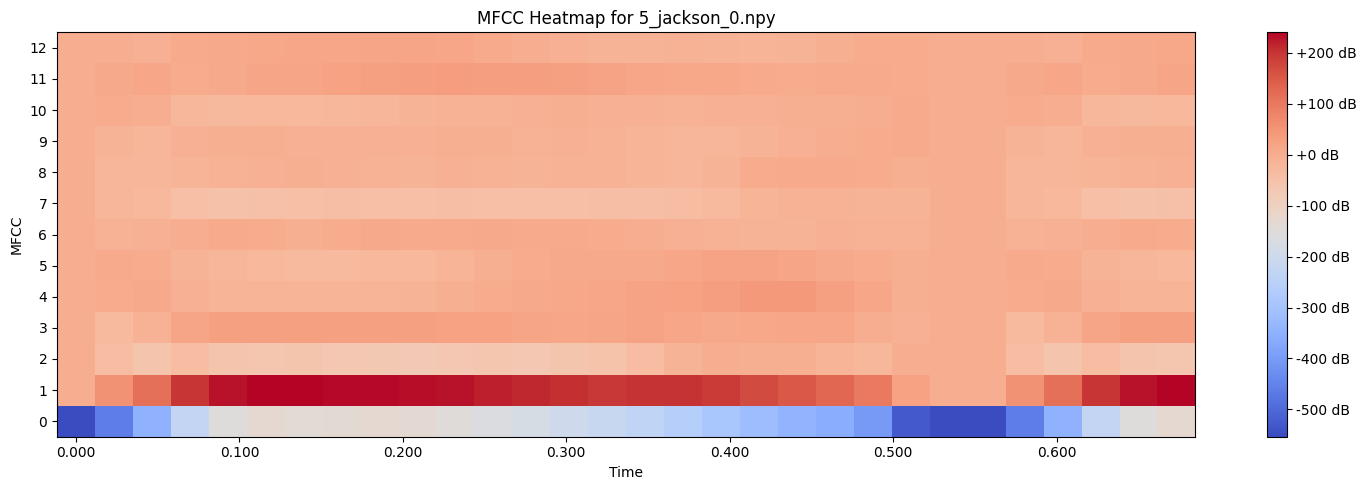

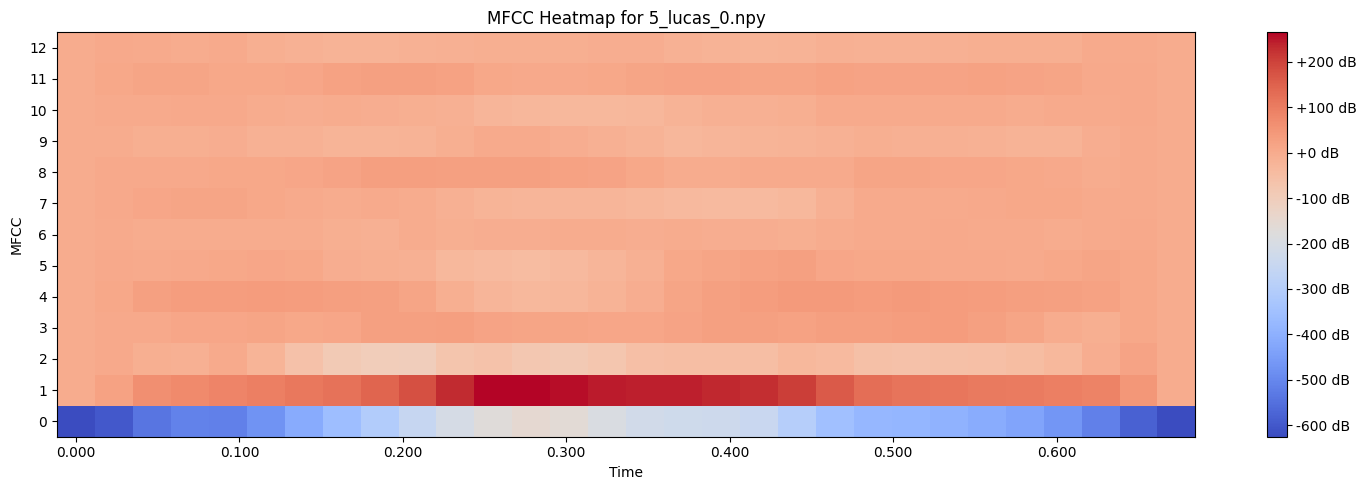

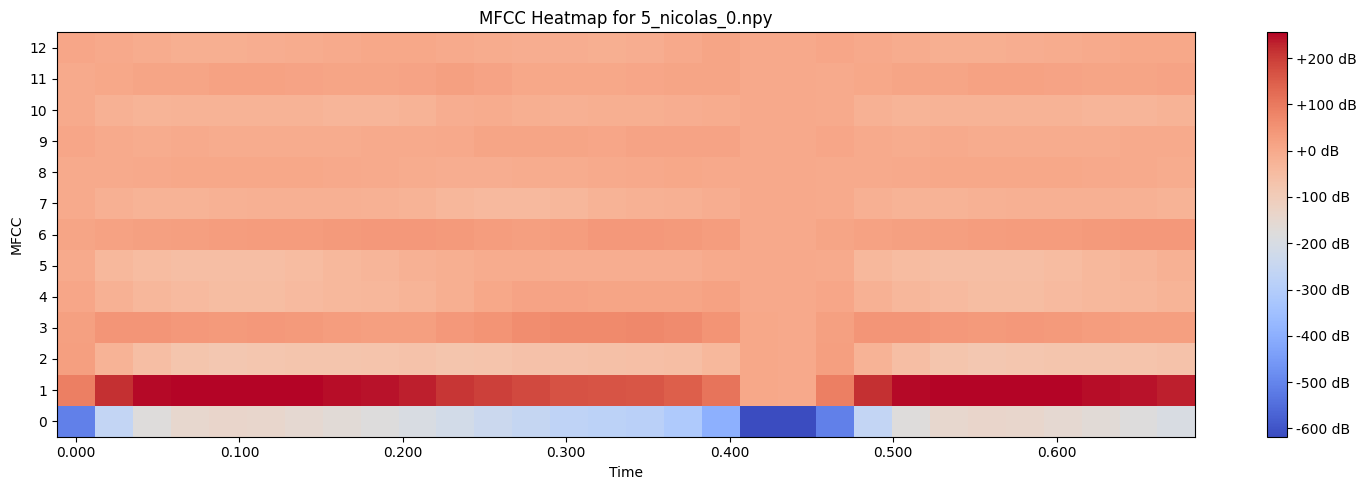

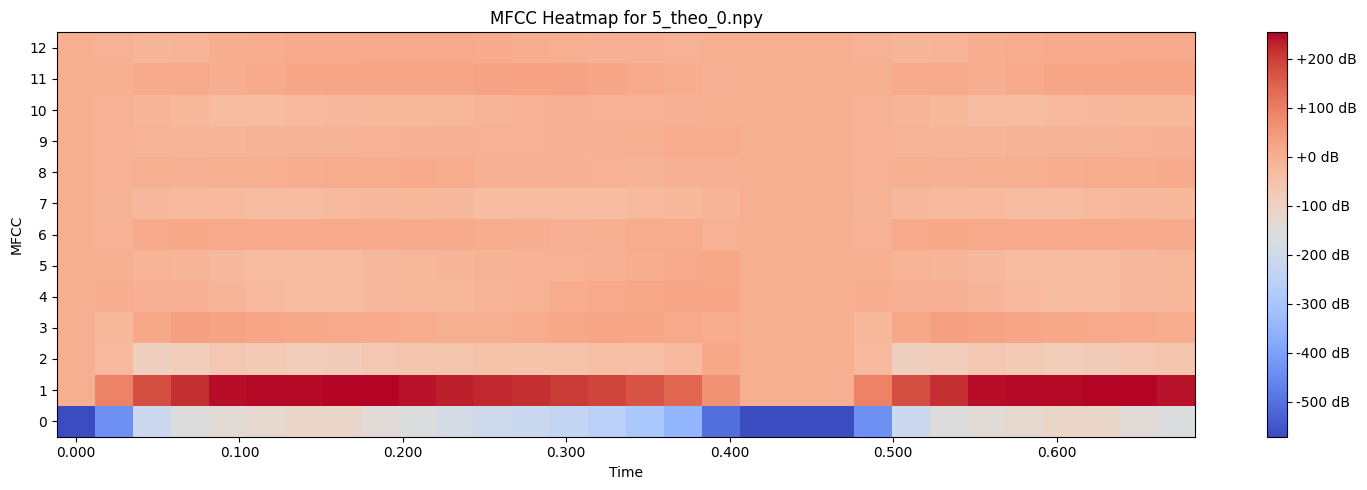

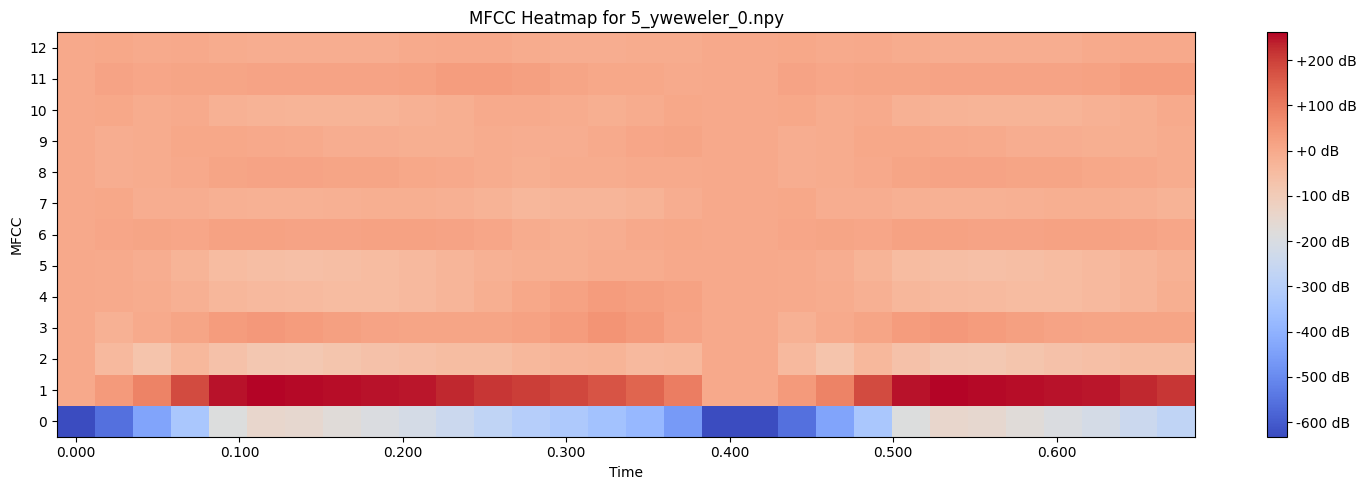

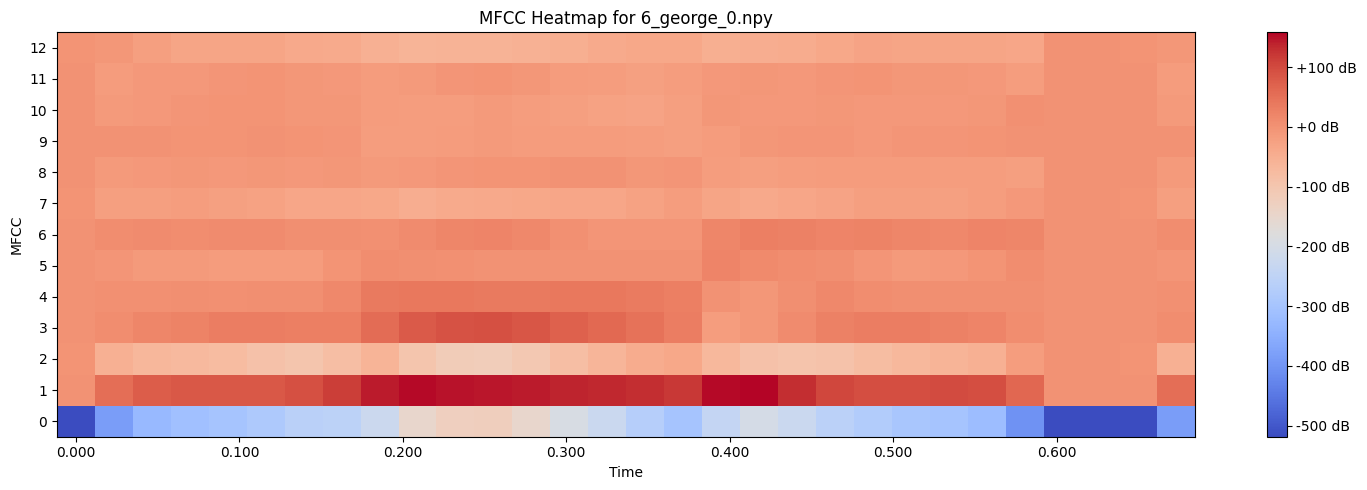

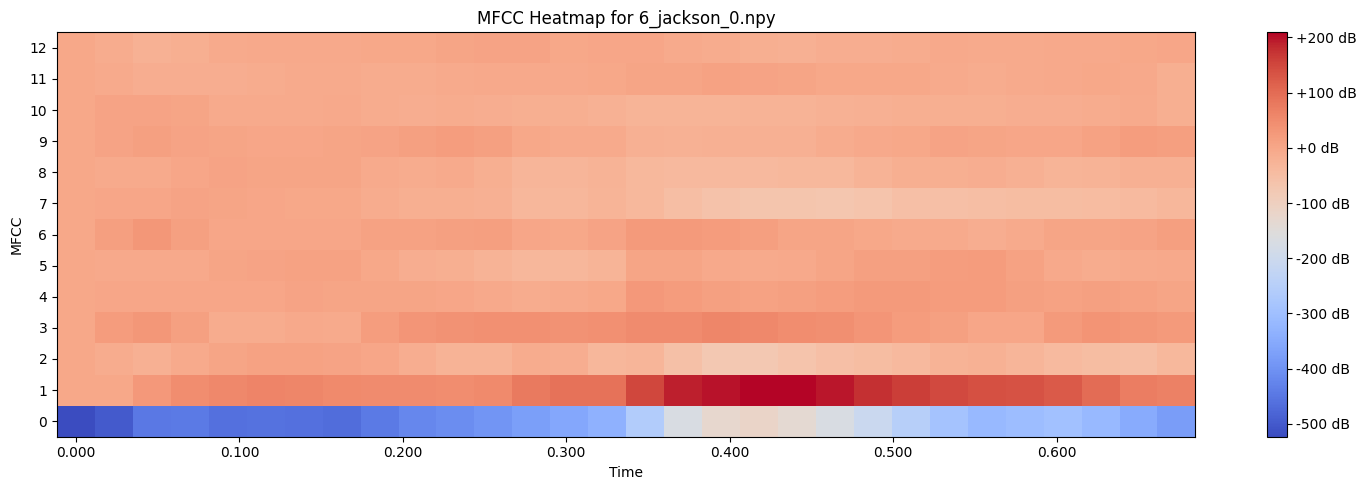

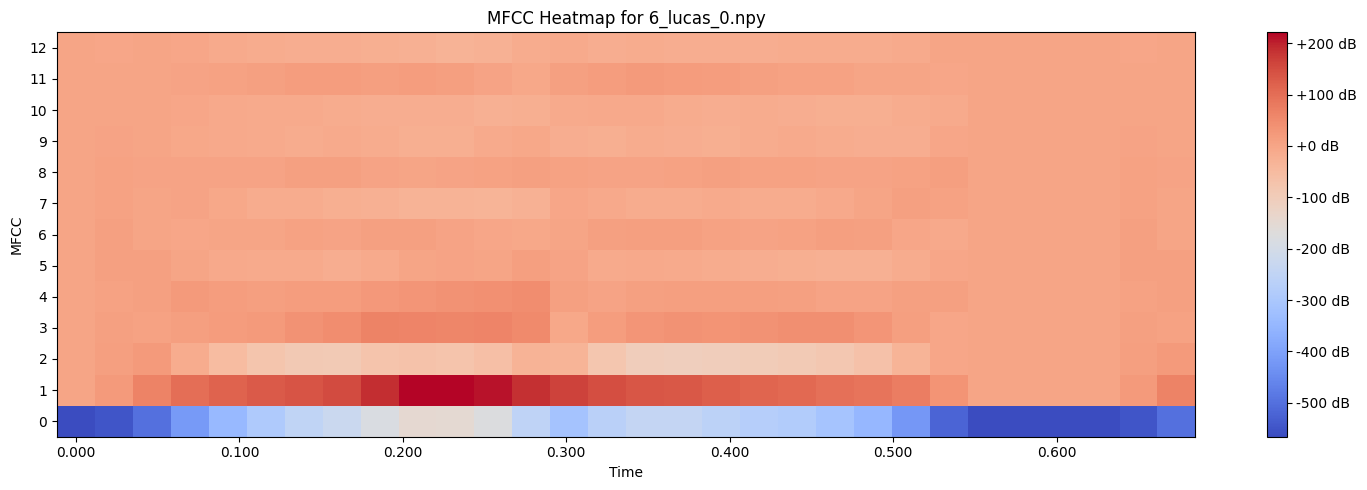

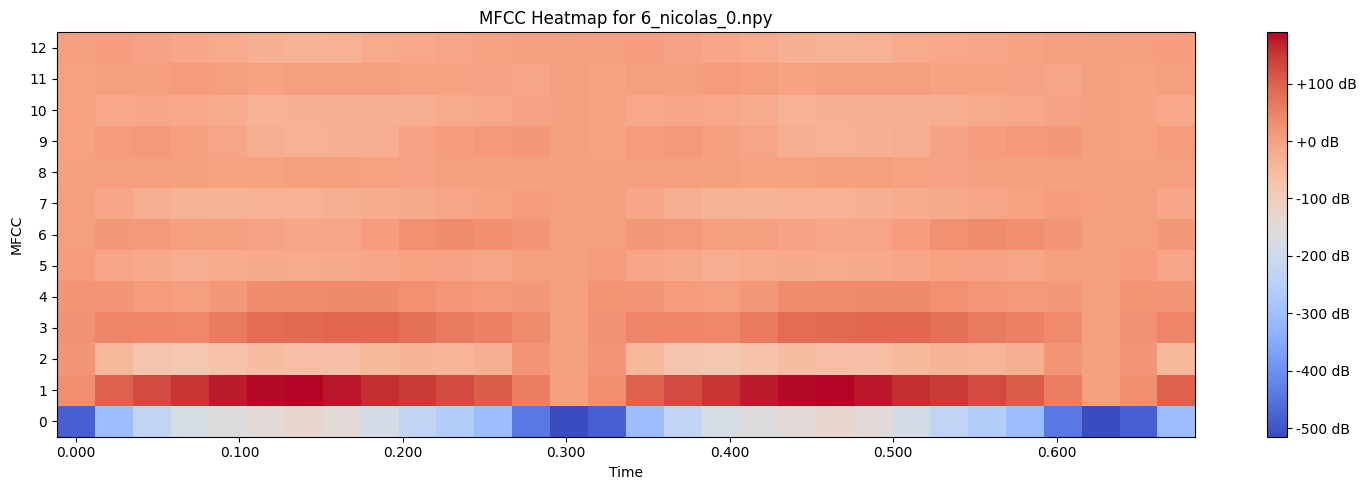

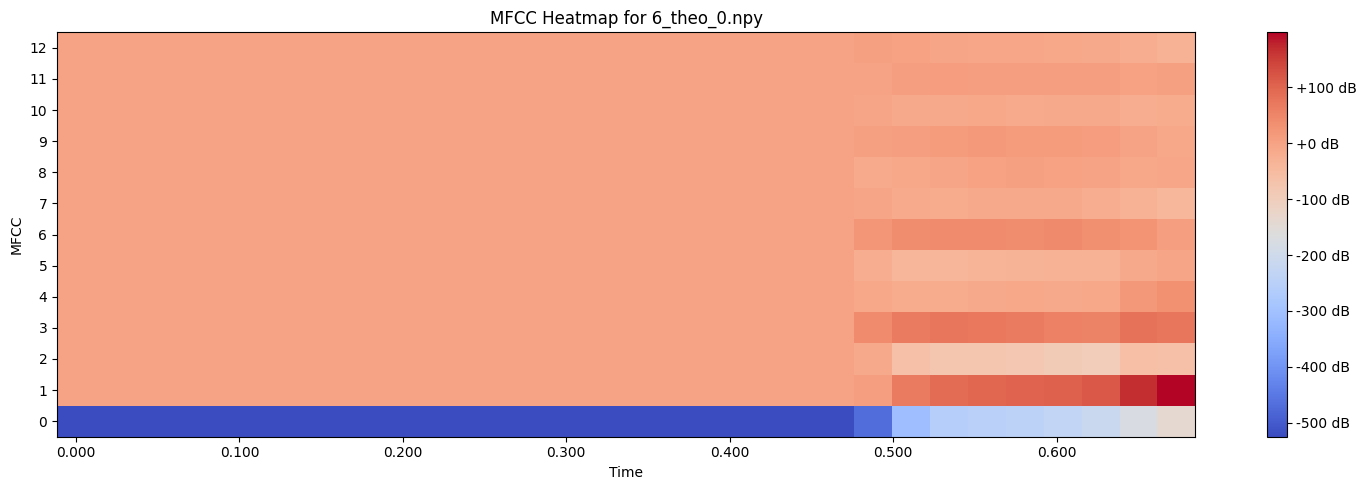

KeyboardInterrupt: 

In [15]:
files_with_index_0 = [f for f in os.listdir(mfcc_features_folder) if f.endswith('_0.npy')]
mfcc_features_index_0 = {file: np.load(os.path.join(mfcc_features_folder, file)) for file in files_with_index_0}
plot_mfcc_heatmaps(mfcc_features_index_0)

# Step Two:

## Prepare Data

In [16]:
def prepare_data(mfcc_folder, num_repeated_recoding = NUM_REPEATED_RECORDING):
    train_features, test_features = [], []
    train_labels, test_labels = [], []

    split_index = num_repeated_recoding * TRAIN_PERCENT
    for file_name in os.listdir(mfcc_folder):
        digit_label, speaker_name, index_str =  file_name[:-4].split('_')
        index = int(index_str)
        file_path = os.path.join(mfcc_folder, file_name)
        file_path = os.path.join(mfcc_folder, file_name)
        mfcc = np.load(file_path)

        if index < split_index:
            train_features.append(mfcc.T)
            train_labels.append(file_name)
        else:
            test_features.append(mfcc.T)
            test_labels.append(file_name)

    return train_features, train_labels, test_features, test_labels

In [17]:
train_features, train_labels, test_features, test_labels = prepare_data(mfcc_features_folder, NUM_REPEATED_RECORDING)

In [18]:
train_labels

['0_george_0.npy',
 '0_george_1.npy',
 '0_george_10.npy',
 '0_george_11.npy',
 '0_george_12.npy',
 '0_george_13.npy',
 '0_george_14.npy',
 '0_george_2.npy',
 '0_george_3.npy',
 '0_george_4.npy',
 '0_george_5.npy',
 '0_george_6.npy',
 '0_george_7.npy',
 '0_george_8.npy',
 '0_george_9.npy',
 '0_jackson_0.npy',
 '0_jackson_1.npy',
 '0_jackson_10.npy',
 '0_jackson_11.npy',
 '0_jackson_12.npy',
 '0_jackson_13.npy',
 '0_jackson_14.npy',
 '0_jackson_2.npy',
 '0_jackson_3.npy',
 '0_jackson_4.npy',
 '0_jackson_5.npy',
 '0_jackson_6.npy',
 '0_jackson_7.npy',
 '0_jackson_8.npy',
 '0_jackson_9.npy',
 '0_lucas_0.npy',
 '0_lucas_1.npy',
 '0_lucas_10.npy',
 '0_lucas_11.npy',
 '0_lucas_12.npy',
 '0_lucas_13.npy',
 '0_lucas_14.npy',
 '0_lucas_2.npy',
 '0_lucas_3.npy',
 '0_lucas_4.npy',
 '0_lucas_5.npy',
 '0_lucas_6.npy',
 '0_lucas_7.npy',
 '0_lucas_8.npy',
 '0_lucas_9.npy',
 '0_nicolas_0.npy',
 '0_nicolas_1.npy',
 '0_nicolas_10.npy',
 '0_nicolas_11.npy',
 '0_nicolas_12.npy',
 '0_nicolas_13.npy',
 '0_ni

In [19]:
test_labels

['0_george_15.npy',
 '0_george_16.npy',
 '0_george_17.npy',
 '0_george_18.npy',
 '0_george_19.npy',
 '0_george_20.npy',
 '0_george_21.npy',
 '0_george_22.npy',
 '0_george_23.npy',
 '0_george_24.npy',
 '0_george_25.npy',
 '0_george_26.npy',
 '0_george_27.npy',
 '0_george_28.npy',
 '0_george_29.npy',
 '0_george_30.npy',
 '0_george_31.npy',
 '0_george_32.npy',
 '0_george_33.npy',
 '0_george_34.npy',
 '0_george_35.npy',
 '0_george_36.npy',
 '0_george_37.npy',
 '0_george_38.npy',
 '0_george_39.npy',
 '0_george_40.npy',
 '0_george_41.npy',
 '0_george_42.npy',
 '0_george_43.npy',
 '0_george_44.npy',
 '0_george_45.npy',
 '0_george_46.npy',
 '0_george_47.npy',
 '0_george_48.npy',
 '0_george_49.npy',
 '0_jackson_15.npy',
 '0_jackson_16.npy',
 '0_jackson_17.npy',
 '0_jackson_18.npy',
 '0_jackson_19.npy',
 '0_jackson_20.npy',
 '0_jackson_21.npy',
 '0_jackson_22.npy',
 '0_jackson_23.npy',
 '0_jackson_24.npy',
 '0_jackson_25.npy',
 '0_jackson_26.npy',
 '0_jackson_27.npy',
 '0_jackson_28.npy',
 '0_ja

## HMM:

# Step Three: Training and Testing

In [112]:
def print_detailed_report(arr1, arr2):
    for i in range(len(arr1)):
        print(i)
        if arr1[i] != arr2[i]:
            print(Fore.RED + f"\033[1m{arr1[i], arr2[i]}\033[0m"+ Style.RESET_ALL)
        else:
            print(Fore.BLUE  + f"{arr1[i], arr2[i]}"+ Style.RESET_ALL)

In [113]:
def extract_digit(label):
    digit_label = label.split('_')[0]
    return digit_label

def extract_speaker(label):
    speaker_label = label.split('_')[1]
    return speaker_label

In [23]:
# Organize training data by digit
training_data_by_digit = defaultdict(list)
for mfcc, label in zip(train_features, train_labels):
    digit = extract_digit(label)
    training_data_by_digit[digit].append(mfcc)

# Organize training data by speaker
training_data_by_speaker = defaultdict(list)
for mfcc, label in zip(train_features, train_labels):
    speaker = extract_speaker(label)
    training_data_by_speaker[speaker].append(mfcc)

In [24]:
test_true_digits = [extract_digit(label) for label in test_labels]
test_true_speakers = [extract_speaker(label) for label in test_labels]

## Part 1:

#### Digit:

In [25]:
hmm_models_digit_1 = {}

for digit, data in training_data_by_digit.items():
    lengths = [len(sequence) for sequence in data]
    X = np.concatenate(data)
    model = hmm.GaussianHMM(n_components = NUM_STATE)
    model.fit(X, lengths)
    hmm_models_digit_1[digit] = model


In [26]:
test_predictions_digits_1 = []

for mfcc in test_features:
    best_score, best_digit = float("-inf"), None
    for digit, model in hmm_models_digit_1.items():
        score = model.score(mfcc)
        if score > best_score:
            best_score, best_digit = score, digit
    test_predictions_digits_1.append(best_digit)


#### Speaker:

In [29]:
hmm_models_speaker_1 = {}

for speaker, data in training_data_by_speaker.items():
    lengths = [len(sequence) for sequence in data]
    X = np.concatenate(data)
    model = hmm.GaussianHMM(n_components = NUM_STATE)
    model.fit(X, lengths)
    hmm_models_speaker_1[speaker] = model


In [30]:
test_predictions_speakers_1 = []

for mfcc in test_features:
    best_score, best_speaker = float("-inf"), None
    for speaker, model in hmm_models_speaker_1.items():
        score = model.score(mfcc)
        if score > best_score:
            best_score, best_speaker = score, speaker
    test_predictions_speakers_1.append(best_speaker)


## Part 2:

### Define HMM class

In [33]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = observation_matrix[:, t] * self.initial_prob.flatten() * observation_matrix[:, t]
                ## TODO: Forward algorithm for the first time step
            else:
                alpha[:, t] = observation_matrix[:, t] * np.dot(alpha[:, t-1], self.transition_matrix)
                ## TODO: Forward algorithm for the next time steps

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.transition_matrix.T,(observation_matrix[:, t+1] * beta[:, t+1]))
            ## TODO: Backward algorithm for the time steps of the HMM
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            mean_T =self.mean[:, s].T
            covariance_T = self.covariances[:, :, s].T
            obs_T = obs.T
            B[s, :] = scipy.stats.multivariate_normal.pdf(x = obs_T, mean=mean_T, cov=covariance_T)
            ## TODO: Compute the likelihood of observations with multivariate normal pdf
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=0)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(
                np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros(
                (self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs) ## TODO

        log_likelihood, alpha = self._forward(B) ## TODO
        beta = self._backward(B) ## TODO

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = self.transition_matrix.T * np.inner(np.outer(B[:, t + 1],beta[:, t + 1]), alpha[:, t]) ## TODO
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t] ## TODO
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, -1] * beta[:, -1] ## TODO
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0] ## TODO
        expected_transition = self._stochasticize(xi_sum)

        expected_covariances = np.zeros(
            (self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(
                gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):


            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

### Digit:

In [34]:
hmm_models_digit_2 = {}

for digit, data in training_data_by_digit.items():
    model = HMM(num_hidden_states = NUM_STATE)
    X = np.concatenate(data)
    model.train(X.T, NUM_ITERATION)
    hmm_models_digit_2[digit] = model

In [35]:
test_predictions_digits_2 = []

for mfcc in test_features:
    best_score, best_digit = float("-inf"), None
    for digit, model in hmm_models_digit_2.items():
        score = model.score(mfcc.T)
        if score > best_score:
            best_score, best_digit = score, digit
    test_predictions_digits_2.append(best_digit)

### Speaker:

In [42]:
hmm_models_speaker_2 = {}

for speaker, data in training_data_by_speaker.items():
    model = HMM(num_hidden_states = NUM_STATE)
    X = np.concatenate(data)
    model.train(X.T, NUM_ITERATION)
    hmm_models_speaker_2[speaker] = model

In [43]:
test_predictions_speakers_2 = []

for mfcc in test_features:
    best_score, best_speker = float("-inf"), None
    for speaker, model in hmm_models_speaker_2.items():
        score = model.score(mfcc.T)
        if score > best_score:
            best_score, best_speker = score, speaker
    test_predictions_speakers_2.append(best_speker)

# Step Four: Results

## Confusion Matrix:

In [135]:
def plot_confusion_matrix(true_vals, predict_vals, vals, type, part):
    cm = confusion_matrix(true_vals, predict_vals)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdBu)
    plt.colorbar()
    label_pos = np.arange(len(vals))
    plt.xticks(label_pos, vals)
    plt.yticks(label_pos, vals)

    for i in range(len(vals)):
        for j in range(len(vals)):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black" )
    plt.xlabel("Predicted " + type)
    plt.ylabel("True" + type)
    plt.title("Confusion Matrix: " + type + "-" + part)
    plt.show()

In [ ]:
DIGITS = list(set(test_true_digits))
DIGITS = sorted(DIGITS)
print(DIGITS)
plot_confusion_matrix(test_true_digits,test_predictions_digits_1, DIGITS, "digits", "part 1")
plot_confusion_matrix(test_true_digits,test_predictions_digits_2, DIGITS, "digits", "part 2")

In [ ]:
SPEAKERS = list(set(test_true_speakers))
SPEAKERS = sorted(SPEAKERS)
print(SPEAKERS)
plot_confusion_matrix(test_true_speakers,test_predictions_speakers_1, SPEAKERS, "speakers", "part 1")
plot_confusion_matrix(test_true_speakers,test_predictions_speakers_2, SPEAKERS, "speakers", "part 2")

## Accuracy:

In [197]:
def print_accuracy(true_vals, predict_vals, vals):
    accs = []
    for val in vals:
        i = 0
        true = 0
        n = 0
        for i in range(len(true_vals)):
            if true_vals[i] == val:
                if true_vals[i] == predict_vals[i]:
                    true = true + 1
                n = n + 1
        print(f"   {val} accuracy = {true/n * 100:.2f} %")
        accs.append(true/n)
    print(f"avg accuracy = {sum(accs)/len(accs) * 100:.2f}%")
    print("--" * 15)

In [194]:
def print_accuracies(true_vals, predict_vals_1, predict_vals_2, vals, type):
    print("accuracies for " + type + "-" + "part 1:")
    print_accuracy(true_vals, predict_vals_1, vals)
    print("accuracies for " + type + "-" + "part 2:")
    print_accuracy(true_vals, predict_vals_2, vals)

In [195]:
print_accuracies(test_true_digits, test_predictions_digits_1, test_predictions_digits_2, DIGITS, "digits")

accuracies for digits-part 1:
   0 accuracy = 92.38 %
   1 accuracy = 91.90 %
   2 accuracy = 96.19 %
   3 accuracy = 85.71 %
   4 accuracy = 90.00 %
   5 accuracy = 91.43 %
   6 accuracy = 91.90 %
   7 accuracy = 88.10 %
   8 accuracy = 94.29 %
   9 accuracy = 92.86 %
avg accuracy = 91.48%
------------------------------
accuracies for digits-part 2:
   0 accuracy = 73.81 %
   1 accuracy = 90.00 %
   2 accuracy = 79.05 %
   3 accuracy = 56.67 %
   4 accuracy = 88.57 %
   5 accuracy = 81.90 %
   6 accuracy = 92.86 %
   7 accuracy = 96.19 %
   8 accuracy = 87.14 %
   9 accuracy = 77.14 %
avg accuracy = 82.33%
------------------------------


In [196]:
print_accuracies(test_true_speakers, test_predictions_speakers_1, test_predictions_speakers_2, SPEAKERS, "speakers")

accuracies for speakers-part 1:
   george accuracy = 99.71 %
   jackson accuracy = 86.29 %
   lucas accuracy = 98.57 %
   nicolas accuracy = 96.86 %
   theo accuracy = 90.29 %
   yweweler accuracy = 88.29 %
avg accuracy = 93.33%
------------------------------
accuracies for speakers-part 2:
   george accuracy = 99.71 %
   jackson accuracy = 84.57 %
   lucas accuracy = 99.71 %
   nicolas accuracy = 99.71 %
   theo accuracy = 62.29 %
   yweweler accuracy = 73.43 %
avg accuracy = 86.57%
------------------------------


## Precision:

In [ ]:
def print_precision(true_vals, predict_vals, vals):
    accs = []
    for val in vals:
        i = 0
        true = 0
        n = 0
        for i in range(len(true_vals)):
            if true_vals[i] == val:
                if true_vals[i] == predict_vals[i]:
                    true = true + 1
                n = n + 1
        print(f"   {val} accuracy = {true/n * 100:.2f} %")
        accs.append(true/n)
    print(f"avg accuracy = {sum(accs)/len(accs) * 100:.2f}%")
    print("--" * 15)